In [5]:
using PyPlot, LightGraphs

In [6]:
srand(1)
t = [ones(10,10) * 10 ones(10,10) * 5; -ones(10,10) * 5 zeros(10,10)];
y = t + randn(20,20)

20×20 Array{Float64,2}:
 10.2973    8.27024   8.71095   8.52938  …   5.37867     5.94013    4.60623  
 10.3824   10.7959    9.66473   9.46479      4.48914     4.9315     6.59105  
  9.40237  10.6701   10.0705    9.03646      5.26241     4.99871    5.26835  
  9.98955  10.5509   10.3418    8.61489      3.38967     4.61464    2.53636  
  9.16097   9.93663  11.7352   10.1343       3.22503     5.04414    6.53105  
 10.3111   11.3369   11.2999    9.38388  …   4.33354     5.54472    4.47687  
 12.2951    9.92685  10.2064    8.28001      6.91683     4.63309    5.58341  
  7.73291   9.25454   8.99114  10.3208       5.16946     4.15181    5.07109  
 10.53      8.77994   9.14994   8.55263      4.23703     5.72098    4.38983  
 10.4314    9.94682  11.1294    9.50773      4.61555     5.86446    6.84181  
 -4.41629  -5.16514  -6.34853  -5.41309  …  -0.197554    0.353621  -0.280518 
 -4.03673  -7.11537  -3.75971  -3.99807      1.0981     -0.530365   0.0124829
 -4.54121  -5.06677  -5.05565  -3.82532 

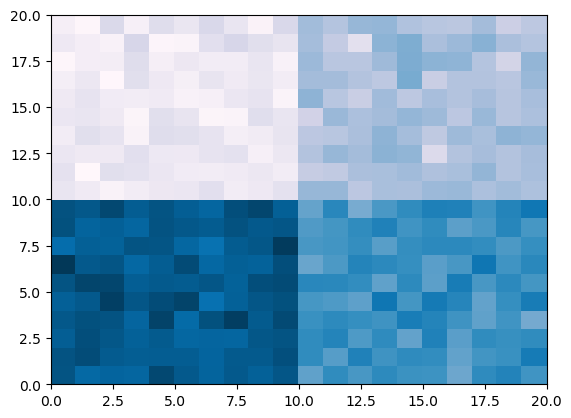

PyObject <matplotlib.collections.QuadMesh object at 0x120a3e510>

In [7]:
pcolormesh(y, cmap = "PuBu")

In [95]:
function BGSM_biclust(Y; init = Y, v0 = 1e-1, sigma = 1, seed = 1, iter = 100, k1 = 2, k2 = 2)
    
    function update(Y,Theta,Mu,sigma,v0; transposed = false)
        n = size(Y,1); k = size(Mu,1);
        diff_sq = reshape(sum((repeat(Theta,outer = [k,1]) - repeat(Mu,inner = [n,1])).^2,2),n,k);
        Q = exp.(-diff_sq/(v0*sigma^2));
        Q = Q./ sum(Q,2);
        R = Diagonal(1./sum(Q,1)[:]) * Q';
        Theta = (eye(n) + (eye(n) - Q * R)/v0)\Y;
        Mu = R * Theta;
        if transposed == false return Theta, Mu, Q
        else return Theta', Mu', Q'
        end
    end
    
    # initialize
    srand(seed)
    n1,n2 = size(Y);
    Theta = init + 0.0 * randn(n1,n2);
    S1 = randperm(n1)[1:k1];
    S2 = randperm(n2)[1:k2];
    Mu1 = init[S1,:] + 0.0 * randn(k1,n2);
    Mu2 = init[:,S2] + 0.0 * randn(n1,k2);
    Q1 = randn(n1,k1);
    Q2 = randn(k2,n2);
    
    # loop start
    for i = 1:iter
        Theta, Mu1, Q1 = update(Y,Theta,Mu1,sigma,v0);
        Theta, Mu2, Q2 = update(Y',Theta',Mu2',sigma,v0, transposed = true);
    end
    
    # get a final estimate
    A = (Q2'*Diagonal(1./sum(Q2,2)[:]) * Q2);
    B = (Q1*Diagonal(1./sum(Q1,1)[:]) * Q1')
    g1 = Graph(A .> 1e-3)
    g2 = Graph(B .> 1e-3)
    c1 = connected_components(g1);
    c2 = connected_components(g2);
    ind = c2[1];
    for i = 2:length(c2)
        ind = [ind;c2[i]];
    end
    Final = (B * Theta * A)[ind,:];
    
    return Final, ind, A, B, Theta
end

BSGM_biclust (generic function with 1 method)

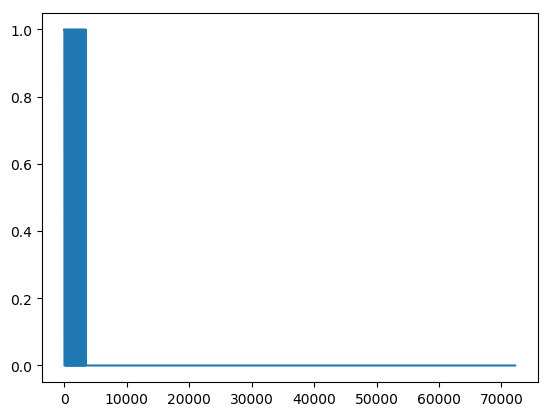

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x107c700d0>

In [111]:
n1, n2 = size(y);
g1 = Graph(ones(n1,n1) - eye(n1));
g2 = Graph(ones(n2,n2) - eye(n2));
p1 = length(edges(g1)); p2 = length(edges(g2));
D1 = -incidence_matrix(g1, oriented = true)';
D2 = -incidence_matrix(g2, oriented = true)';
D12 = kron(D2,D1); D21 = -kron(D2,D1);
D12[D12 .< 0] = 0;
D21[D21 .< 0] = 0;
D = sparse([D12;D21]);
for i = 1:size(D,1)
    ind = find(D[i,:] .> 0);
    D[i,ind[2]] = -1;
end

In [137]:
D[200,:]

400-element SparseVector{Int64,Int64} with 4 stored entries:
  [1  ]  =  1
  [11 ]  =  0
  [41 ]  =  0
  [51 ]  =  -1

In [136]:
D[200 + p1*p2,:]

400-element SparseVector{Int64,Int64} with 4 stored entries:
  [1  ]  =  0
  [11 ]  =  1
  [41 ]  =  -1
  [51 ]  =  0

In [17]:
n1, n2 = size(y);
g1 = PathGraph(n1); g2 = PathGraph(n2);
p1 = length(edges(g1)); p2 = length(edges(g2));
D1 = -incidence_matrix(g1, oriented = true)'
D2 = -incidence_matrix(g2, oriented = true)'
D12 = kron(D2,D1); D21 = -kron(D2,D1);
D12[D12 .< 0] = 0;
D21[D21 .< 0] = 0;
D = sparse([D12;D21]);
for i = 1:size(D,1)
    ind = find(D[i,:] .> 0);
    D[i,ind[2]] = -1;
end

In [126]:
function BGSM_kronecker(y; v0 = 1e-1, v1 = 1e3, c = 1, iter = 100, graditer = 10)

    t = y + 0.0; q1 = ones(p1)/2; q2 = ones(p2)/2; s2 = 1;
    for i = 1:iter
        sqds = reshape(sum(reshape((D*t).^2,p1*p2,2),2)[:],p1,p2)
        t2 = sum(sqds .* repmat(q1,1,p2),1)[:]/n1;
        q2 = 1./( 1 + sqrt(v0/v1) * exp.(t2 * (1/v0 - 1/v1)/(2*s2)) )
        t1 = sum(sqds .* repmat(q2',p1,1),2)[:]/n2;
        q1 = 1./( 1 + sqrt(v0/v1) * exp.(t1 * (c/v0 - c/v1)/(2*s2)) )
        tau1 = q1/v0/c + (1-q1)/v1/c;
        tau2 = q2/v0 + (1-q2)/v1;
        tau = (tau1 .* tau2')[:]; tau = [tau;tau]
        for j = 1:graditer
            t = t - 1e-6 * (t + D' * (tau .* (D * t)) - y)
        end
    end
    
    # get a final estimate
    gamma1 = find(q1 .< 0.5); gamma2 = find(q2 .< 0.5);
    g1 = PathGraph(n1)
    for i in gamma1
        rem_edge!(g1,i,i+1)
    end
    c1 = connected_components(g1);
    C1 = zeros(length(c1),n1)
    for i = 1:length(c1)
        C1[i,c1[i]] = 1;
    end
    B1 = C1'*inv(C1*C1')*C1;
    
    g2 = PathGraph(n2)
    for i in gamma2
        rem_edge!(g2,i,i+1)
    end
    c2 = connected_components(g2);
    C2 = zeros(length(c2),n2)
    for i = 1:length(c2)
        C2[i,c2[i]] = 1;
    end
    B2 = C2'*inv(C2*C2')*C2;
    final = B1*reshape(t,n1,n2)*B2;
    
    
    return final, reshape(t,n1,n2), c1, c2
end

BGSM_kronecker (generic function with 1 method)

In [127]:
final, t, c1, c2 = BGSM_kronecker(y[:], v0 = 1e-1 * 10, c = 1)

LoadError: [91mBoundsError: attempt to access 20-element Array{Array{Int64,1},1} at index [21][39m

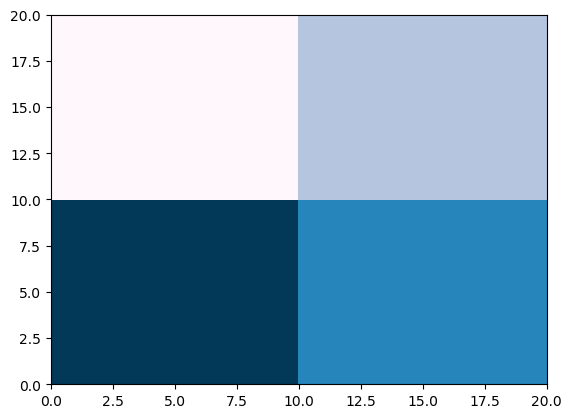

PyObject <matplotlib.collections.QuadMesh object at 0x13a525750>

In [103]:
pcolormesh(final, cmap = "PuBu")

In [55]:
Final, ind, A, B, Theta = BGSM_biclust(y, v0 = 1e-1 * 3, k1 = 5, k2 = 5, iter = 2000)
pcolormesh(Final, cmap = "PuBu")

LoadError: [91mUndefVarError: BGSM_biclust not defined[39m